In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# ! pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+${CUDA}.html
# ! pip install torch-cluster

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# count param numbers

In [ ]:
import torchvision.models as models

# Load the SqueezeNet model
squeezenet = models.squeezenet1_0(pretrained=True)

# Calculate the number of parameters
num_params_squeezenet = sum(p.numel() for p in squeezenet.parameters())

print(f"Number of trainable parameters in SqueezeNet: {num_params_squeezenet}")


Number of trainable parameters in SqueezeNet: 1248424


In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)


# Calculate the number of parameters
num_params_efficientnet = sum(p.numel() for p in efficientnet.parameters())

print(f"Number of trainable parameters in efficientnet: {num_params_efficientnet}")

Number of trainable parameters in efficientnet: 5288548


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
import torch
from torch.nn import Parameter

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Example usage:
# Define your PyTorch model
model = GCN(1, 10)
# Calculate the number of parameters
num_params = count_parameters(model)

print(f"Number of trainable parameters in the model: {num_params}")


Number of trainable parameters in the model: 560


In [ ]:
# Example usage:
# Define your PyTorch model
model = GCN(5, 10)
# Calculate the number of parameters
num_params = count_parameters(model)

print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 600


In [ ]:
# Example usage:
# Define your PyTorch model
model = GCN(32, 10)
# Calculate the number of parameters
num_params = count_parameters(model)

print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 870


In [ ]:
# Example usage:
# Define your PyTorch model
model = GCN(100, 10)
# Calculate the number of parameters
num_params = count_parameters(model)

print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 1550


In [ ]:
# Example usage:
# Define your PyTorch model
model = GCN(200, 10)
# Calculate the number of parameters
num_params = count_parameters(model)

print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 2550


In [ ]:
# Example usage:
# Define your PyTorch model
model = GCN(300, 10)
# Calculate the number of parameters
num_params = count_parameters(model)

print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 3550


# let's try a new code

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 10


class GCN(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        # Init parent
        super(GCN, self).__init__()
        # torch.manual_seed(42)
        # GCN layers
        self.initial_conv = GCNConv(input_size, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        # Output layer
        # self.out = Linear(embedding_size*2, dataset.num_classes)
        self.out = Linear(embedding_size*2, num_classes)
    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)
        # Apply a final (linear) classifier.
        out = self.out(hidden)
        return out, hidden

# print(model)
# print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_to_draw_metrics(data_loader, model, loss_fn, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_total = 0
    result_data = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
            test_loss = loss_fn(pred, batch.y)
            total_loss += test_loss.item()

            _, test_predicted = torch.max(pred.data, 1)
            total_total += batch.y.size(0)
            total_correct += (test_predicted == batch.y).sum().item()

            for i in range(len(batch.y)):
                result_data.append([batch.y[i].item(), test_predicted[i].item()])

    accuracy = total_correct / total_total
    avg_loss = total_loss / len(data_loader)

    columns = ["Real Label", "Predicted Label"]
    df = pd.DataFrame(result_data, columns=columns)

    # Confusion Matrix
    cm = confusion_matrix(df['Real Label'], df['Predicted Label'])
    # Plotting Confusion Matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, and F1 Score
    print(classification_report(df['Real Label'], df['Predicted Label']))

    return avg_loss, accuracy, df

In [ ]:
def pca_the_features(dim, features):
      from sklearn.decomposition import PCA

      # Define the split indices
      train_indices = range(9200)
      val_indices = range(9200, 10000)

      # Split the features into train and validation
      train_features = features[:9200]
      val_features = features[9200:]

      # Apply PCA on the training features
      pca = PCA(n_components=dim)
      pca.fit(train_features)
      train_features_pca = pca.transform(train_features)

      # Apply PCA on the validation features
      val_features_pca = pca.transform(val_features)

      return train_features_pca, val_features_pca


def create_dataset(train_features_pca, val_features_pca):
      import torch
      from torch_geometric.datasets import MNISTSuperpixels
      from sklearn.decomposition import PCA
      from torch_geometric.data import DataLoader

      # Load the dataset
      dataset = MNISTSuperpixels(root='.', train=False)

      # Assuming you have a features list
      # features = [...]  # Replace [...] with your features list

      # Define the split indices
      train_indices = range(9200)
      val_indices = range(9200, 10000)

      # Initialize train and validation datasets
      train_dataset = []
      val_dataset = []

      # Process the dataset and PCA-transformed features
      for i, graph in enumerate(dataset):
          num_nodes = graph.num_nodes

          # Assign PCA-transformed features to the graph's 'x' attribute
          if i in train_indices:
              graph.x = torch.tensor(train_features_pca[i], dtype=torch.float).unsqueeze(0).repeat(num_nodes, 1)
              train_dataset.append(graph)
          elif i in val_indices:
              graph.x = torch.tensor(val_features_pca[i - 9200], dtype=torch.float).unsqueeze(0).repeat(num_nodes, 1)
              val_dataset.append(graph)

      # Print the first graph in the train dataset
      print(train_dataset[0])

      # Print the first graph in the validation dataset
      print(val_dataset[0])

      return train_dataset, val_dataset

def train_model(dim, train_dataset, val_dataset,num_classes=10, draw_metrics=False):
      from torch_geometric.data import DataLoader
      import warnings
      from torch_geometric.data import DataLoader
      warnings.filterwarnings("ignore")

      def train_and_test(data_loader, model, optimizer, loss_fn, device):
          model.train()

          correct = 0
          total = 0
          total_loss = 0

          for batch in data_loader:
              batch = batch.to(device)
              optimizer.zero_grad()
              pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
              loss = loss_fn(pred, batch.y)
              loss.backward()
              optimizer.step()

              _, predicted = torch.max(pred.data, 1)
              total += batch.y.size(0)
              correct += (predicted == batch.y).sum().item()
              total_loss += loss.item()

          accuracy = correct / total
          avg_loss = total_loss / len(data_loader)
          return avg_loss, accuracy

      def evaluate(data_loader, model, loss_fn, device):
          model.eval()
          total_loss = 0
          total_correct = 0
          total_total = 0

          with torch.no_grad():
              for batch in data_loader:
                  batch = batch.to(device)
                  pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
                  test_loss = loss_fn(pred, batch.y)
                  total_loss += test_loss.item()

                  _, test_predicted = torch.max(pred.data, 1)
                  total_total += batch.y.size(0)
                  total_correct += (test_predicted == batch.y).sum().item()

          accuracy = total_correct / total_total
          avg_loss = total_loss / len(data_loader)
          return avg_loss, accuracy



      print("Starting training...")

      best_accuracy = [0.0, 0.0, 0.0, 0.0, 0.0]
      best_accuracy_train = [0.0, 0.0, 0.0, 0.0, 0.0]
      # Initialize lists to store logs for each run
      all_train_losses = []
      all_train_accuracies = []
      all_test_losses = []
      all_test_accuracies = []

      best_accuracy = [0.0] * 5
      best_accuracy_train = [0.0] * 5
      patience = 5

      patience = 5  # Number of epochs without improvement to wait before stopping
      early_stop_counter = 0

      for run_time in [0,1,2,3,4]:
        model = GCN(dim, num_classes)
        # Cross EntrophyLoss
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
        # Use GPU for training
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = model.to(device)

        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []


        # Wrap data in a data loader
        # data_size = len(dataset)
        NUM_GRAPHS_PER_BATCH = 64
        train_loader = DataLoader(train_dataset,
                            batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
        test_loader = DataLoader(val_dataset,
                                batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)



        for epoch in range(40):
            train_loss, train_accuracy = train_and_test(train_loader, model, optimizer, loss_fn, device)
            test_loss, test_accuracy = evaluate(test_loader, model, loss_fn, device)

            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            print(f"Epoch {epoch} | Train Loss {train_loss} | Train Accuracy {train_accuracy} | Test Loss {test_loss} | Test Accuracy {test_accuracy}")




            # add best acc of train
            if train_accuracy > best_accuracy_train[run_time]:
                best_accuracy_train[run_time] = train_accuracy

            # Check for improvement in validation accuracy
            if test_accuracy > best_accuracy[run_time]:
                best_accuracy[run_time] = test_accuracy
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print("Validation accuracy did not improve for several epochs. Stopping early.")
                    break

        # Store logs for this run
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)
        all_test_losses.append(test_losses)
        all_test_accuracies.append(test_accuracies)

      # report best of 5 rounds in train and test
      # FOR TEST
      import statistics
      print(f'best accuraces for test was : {best_accuracy}')
      print(f'stddev for test was  : {statistics.stdev(best_accuracy)}')

      # FOR Train
      print(f'best accuraces for test was : {best_accuracy_train}')
      print(f'stddev for test was  : {statistics.stdev(best_accuracy_train)}')

      if draw_metrics:
        evaluate_to_draw_metrics(test_loader, model, loss_fn, device)


      return all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies



def run_experiment(dim,  features, show_metric=False):
      train_features_pca, val_features_pca = pca_the_features(dim, features)
      train_dataset, val_dataset = create_dataset(train_features_pca, val_features_pca)
      logs = train_model(dim, train_dataset, val_dataset, num_classes = 10, draw_metrics=show_metric)
      return logs

def run_experiment_no_pca(dim,  train_features, val_features, show_metric=False):

      train_dataset, val_dataset = create_dataset(train_features, val_features)
      logs = train_model(dim, train_dataset, val_dataset, num_classes = 10, draw_metrics=show_metric)
      return logs

def akbar(dim,  features, show_metric=False):
      train_features_pca, val_features_pca = pca_the_features(dim, features)
      train_dataset, val_dataset = create_dataset(train_features_pca, val_features_pca)
      logs = train_model(dim, train_dataset, val_dataset, num_classes = 10, draw_metrics=show_metric)
      return logs


# load feature

In [ ]:
import numpy as np
features = np.load('/content/drive/MyDrive/tmp/features_squeeze_86528.npy')



In [ ]:
import pickle
file = open("/content/drive/MyDrive/tmp/mnist_features_train_false_efficientb0.pkl",'rb')
features_efficient = pickle.load(file)

In [ ]:
with open('/content/drive/MyDrive/tmp/logssq5.pkl', 'rb') as file:
        logssq5_loaded = pickle.load(file)

In [ ]:
import numpy as np

test_acc = [0.8725, 0.8875, 0.8975, 0.83625, 0.8775]

np.array(test_acc).mean()

# sq 32

In [ ]:
logssq32 =  run_experiment(32, features)
with open('/content/drive/MyDrive/tmp/logssq32.pkl', 'wb') as file:
        pickle.dump(logssq32, file)

Data(x=[75, 32], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 32], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.1672484891282187 | Train Accuracy 0.2192391304347826 | Test Loss 1.9703429478865404 | Test Accuracy 0.3275
Epoch 1 | Train Loss 1.7943696081638336 | Train Accuracy 0.45206521739130434 | Test Loss 1.663704826281621 | Test Accuracy 0.4875
Epoch 2 | Train Loss 1.4989558681845665 | Train Accuracy 0.5458695652173913 | Test Loss 1.3995998272529016 | Test Accuracy 0.6075
Epoch 3 | Train Loss 1.251665157576402 | Train Accuracy 0.6365217391304347 | Test Loss 1.1559660251323993 | Test Accuracy 0.67625
Epoch 4 | Train Loss 1.058025526917643 | Train Accuracy 0.6972826086956522 | Test Loss 0.9694657784241897 | Test Accuracy 0.7225
Epoch 5 | Train Loss 0.9039843107263247 | Train Accuracy 0.7416304347826087 | Test Loss 0.8749451637268066 | Test Accuracy 0.755
Epoch 6 | Train Loss 0.8085913892007537 | Train Accuracy 0.7655434782608695 | Test 

In [5]:
import numpy as np

test_acc = [0.8725, 0.8875, 0.8975, 0.83625, 0.8775]

np.array(test_acc).mean()

0.87425

# squeeze 5

In [ ]:
logssq5 = akbar(5, features)

Data(x=[75, 5], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 5], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.044776117636098 | Train Accuracy 0.2966304347826087 | Test Loss 1.7313865973399236 | Test Accuracy 0.46
Epoch 1 | Train Loss 1.5256156507465575 | Train Accuracy 0.5002173913043478 | Test Loss 1.343080080472506 | Test Accuracy 0.59375
Epoch 2 | Train Loss 1.2646480161282752 | Train Accuracy 0.5834782608695652 | Test Loss 1.1476550973378694 | Test Accuracy 0.5925
Epoch 3 | Train Loss 1.1391245929731264 | Train Accuracy 0.6034782608695652 | Test Loss 1.067445273582752 | Test Accuracy 0.60875
Epoch 4 | Train Loss 1.063641607347462 | Train Accuracy 0.6240217391304348 | Test Loss 1.0057832782085125 | Test Accuracy 0.6175
Epoch 5 | Train Loss 1.0135492831468582 | Train Accuracy 0.6478260869565218 | Test Loss 0.953297665485969 | Test Accuracy 0.685
Epoch 6 | Train Loss 0.9731278522974915 | Train Accuracy 0.6707608695652174 | Test Loss 0

In [7]:
import numpy as np

test_acc = [0.7175, 0.72625, 0.74625, 0.74375, 0.73125]

np.array(test_acc).mean()

0.733

In [ ]:
import pickle

with open('/content/drive/MyDrive/tmp/logssq5.pkl', 'wb') as file:
        pickle.dump(logssq5, file)

# sq 1

In [ ]:
logssq1 = akbar(1, features)

Data(x=[75, 1], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 1], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.072137428654565 | Train Accuracy 0.17402173913043478 | Test Loss 1.8643934084818914 | Test Accuracy 0.20375
Epoch 1 | Train Loss 1.83225938760572 | Train Accuracy 0.21706521739130435 | Test Loss 1.7881387563852162 | Test Accuracy 0.25125
Epoch 2 | Train Loss 1.7645333550042577 | Train Accuracy 0.2348913043478261 | Test Loss 1.703175159601065 | Test Accuracy 0.2575
Epoch 3 | Train Loss 1.7229889647828207 | Train Accuracy 0.25206521739130433 | Test Loss 1.6802945045324473 | Test Accuracy 0.255
Epoch 4 | Train Loss 1.7111139620343845 | Train Accuracy 0.24239130434782608 | Test Loss 1.6666631423510039 | Test Accuracy 0.225
Epoch 5 | Train Loss 1.6961135781473584 | Train Accuracy 0.25282608695652176 | Test Loss 1.6425740443743193 | Test Accuracy 0.25625
Epoch 6 | Train Loss 1.6881839194231563 | Train Accuracy 0.25119565217391304 | Te

In [6]:
import numpy as np

test_acc = [0.2575, 0.275, 0.3025, 0.30125, 0.30375]

np.array(test_acc).mean()

0.288

In [ ]:
with open('/content/drive/MyDrive/tmp/logssq1.pkl', 'wb') as file:
        pickle.dump(logssq1, file)

# squeeze 100

In [ ]:
logssq100 =  run_experiment(100, features)
with open('/content/drive/MyDrive/tmp/logssq100.pkl', 'wb') as file:
        pickle.dump(logssq100, file)

Data(x=[75, 100], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 100], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.069312012030019 | Train Accuracy 0.31228260869565216 | Test Loss 1.859796900015611 | Test Accuracy 0.39875
Epoch 1 | Train Loss 1.670549213886261 | Train Accuracy 0.4677173913043478 | Test Loss 1.501000587756817 | Test Accuracy 0.55875
Epoch 2 | Train Loss 1.351069809661971 | Train Accuracy 0.5854347826086956 | Test Loss 1.2722674516531138 | Test Accuracy 0.6
Epoch 3 | Train Loss 1.122127856231398 | Train Accuracy 0.6665217391304348 | Test Loss 1.0723542066720815 | Test Accuracy 0.67625
Epoch 4 | Train Loss 0.9527563518948026 | Train Accuracy 0.7164130434782608 | Test Loss 0.9102590817671555 | Test Accuracy 0.72875
Epoch 5 | Train Loss 0.8083324817319711 | Train Accuracy 0.7627173913043478 | Test Loss 0.7592953856174762 | Test Accuracy 0.78875
Epoch 6 | Train Loss 0.7005931308699979 | Train Accuracy 0.7928260869565218 | Test

In [8]:
import numpy as np

test_acc = [0.92375, 0.92125, 0.94375, 0.91875, 0.9275]

np.array(test_acc).mean()

0.9269999999999999

# squeeze 200

In [ ]:
logssq200 = run_experiment(200, features)
with open('/content/drive/MyDrive/tmp/logssq200.pkl', 'wb') as file:
        pickle.dump(logssq200, file)

Data(x=[75, 200], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 200], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.1719609556926622 | Train Accuracy 0.22239130434782609 | Test Loss 1.9813783994087806 | Test Accuracy 0.3175
Epoch 1 | Train Loss 1.8103919186525874 | Train Accuracy 0.398804347826087 | Test Loss 1.5918881984857411 | Test Accuracy 0.4925
Epoch 2 | Train Loss 1.4773797765374184 | Train Accuracy 0.5079347826086956 | Test Loss 1.2775145494020903 | Test Accuracy 0.58625
Epoch 3 | Train Loss 1.238030665864547 | Train Accuracy 0.591195652173913 | Test Loss 1.0799518319276662 | Test Accuracy 0.64375
Epoch 4 | Train Loss 1.065044704824686 | Train Accuracy 0.658804347826087 | Test Loss 0.9670122082416828 | Test Accuracy 0.69625
Epoch 5 | Train Loss 0.9203199243379964 | Train Accuracy 0.7143478260869566 | Test Loss 0.8159631903354938 | Test Accuracy 0.7475
Epoch 6 | Train Loss 0.7926653284165595 | Train Accuracy 0.7581521739130435 | Te

In [9]:
import numpy as np

test_acc = [0.935, 0.925, 0.9375, 0.93, 0.94]

np.array(test_acc).mean()

0.9335000000000001

# squeeze 300

In [ ]:
logssq300 = run_experiment(300, features)
with open('/content/drive/MyDrive/tmp/logssq300.pkl', 'wb') as file:
        pickle.dump(logssq300, file)

Data(x=[75, 300], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 300], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.150854040351179 | Train Accuracy 0.2257608695652174 | Test Loss 1.9765421152114868 | Test Accuracy 0.3775
Epoch 1 | Train Loss 1.7449636401401625 | Train Accuracy 0.4225 | Test Loss 1.5677334253604596 | Test Accuracy 0.5025
Epoch 2 | Train Loss 1.3582947908176317 | Train Accuracy 0.5809782608695652 | Test Loss 1.2565540075302124 | Test Accuracy 0.60875
Epoch 3 | Train Loss 1.0816227959262 | Train Accuracy 0.6845652173913044 | Test Loss 1.0435980879343474 | Test Accuracy 0.695
Epoch 4 | Train Loss 0.8772104370097319 | Train Accuracy 0.7570652173913044 | Test Loss 0.8636716237434974 | Test Accuracy 0.7525
Epoch 5 | Train Loss 0.7248963357673751 | Train Accuracy 0.7956521739130434 | Test Loss 0.7387260381992047 | Test Accuracy 0.785
Epoch 6 | Train Loss 0.6134283368786176 | Train Accuracy 0.8280434782608695 | Test Loss 0.652509

In [10]:
import numpy as np

test_acc = [0.93625, 0.92125, 0.94875, 0.91, 0.9125]

np.array(test_acc).mean()

0.9257500000000001

# efficient 1

In [ ]:
logsef1 = run_experiment(1, features_efficient)
with open('/content/drive/MyDrive/tmp/logsef1.pkl', 'wb') as file:
        pickle.dump(logsef1, file)

Data(x=[75, 1], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 1], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.1406043569246926 | Train Accuracy 0.18717391304347827 | Test Loss 2.021116458452665 | Test Accuracy 0.22375
Epoch 1 | Train Loss 1.9360927500658565 | Train Accuracy 0.2232608695652174 | Test Loss 1.9579731867863581 | Test Accuracy 0.23875
Epoch 2 | Train Loss 1.847867540187306 | Train Accuracy 0.2597826086956522 | Test Loss 1.8536790150862474 | Test Accuracy 0.26375
Epoch 3 | Train Loss 1.763752109474606 | Train Accuracy 0.31228260869565216 | Test Loss 1.7820335626602173 | Test Accuracy 0.30875
Epoch 4 | Train Loss 1.6862075767583318 | Train Accuracy 0.3467391304347826 | Test Loss 1.7163623754794781 | Test Accuracy 0.345
Epoch 5 | Train Loss 1.6277850791811943 | Train Accuracy 0.36630434782608695 | Test Loss 1.7011804488989024 | Test Accuracy 0.355
Epoch 6 | Train Loss 1.5956923365592957 | Train Accuracy 0.3758695652173913 | Tes

In [11]:
import numpy as np

test_acc = [0.3675, 0.37125, 0.375, 0.36875, 0.37375]

np.array(test_acc).mean()

0.37124999999999997

# efficient 5

In [ ]:
logsef5 = run_experiment(5, features_efficient)
with open('/content/drive/MyDrive/tmp/logsef5.pkl', 'wb') as file:
        pickle.dump(logsef5, file)

Data(x=[75, 5], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 5], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 1.9460570100280974 | Train Accuracy 0.36782608695652175 | Test Loss 1.653708265377925 | Test Accuracy 0.48875
Epoch 1 | Train Loss 1.437923011680444 | Train Accuracy 0.5638043478260869 | Test Loss 1.274550777215224 | Test Accuracy 0.6
Epoch 2 | Train Loss 1.1502849554849996 | Train Accuracy 0.6476086956521739 | Test Loss 1.1225292911896338 | Test Accuracy 0.66625
Epoch 3 | Train Loss 1.006902853647868 | Train Accuracy 0.6834782608695652 | Test Loss 1.0072645774254432 | Test Accuracy 0.685
Epoch 4 | Train Loss 0.9217266088558568 | Train Accuracy 0.6985869565217391 | Test Loss 0.9512693515190711 | Test Accuracy 0.7
Epoch 5 | Train Loss 0.8599148549967341 | Train Accuracy 0.7168478260869565 | Test Loss 0.9092935002767123 | Test Accuracy 0.71625
Epoch 6 | Train Loss 0.817267840107282 | Train Accuracy 0.731304347826087 | Test Loss 0.88

In [12]:
import numpy as np

test_acc = [0.71625, 0.7175, 0.6925, 0.71625, 0.73]

np.array(test_acc).mean()

0.7145

# efficient 32

Data(x=[75, 32], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 32], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.013024782968892 | Train Accuracy 0.35032608695652173 | Test Loss 1.7231546548696666 | Test Accuracy 0.4925
Epoch 1 | Train Loss 1.4357592016458511 | Train Accuracy 0.6009782608695652 | Test Loss 1.2535647520652184 | Test Accuracy 0.66
Epoch 2 | Train Loss 1.035349566489458 | Train Accuracy 0.7047826086956521 | Test Loss 0.9774390504910395 | Test Accuracy 0.72
Epoch 3 | Train Loss 0.8201855536964204 | Train Accuracy 0.7486956521739131 | Test Loss 0.8425729274749756 | Test Accuracy 0.72125
Epoch 4 | Train Loss 0.704199635113279 | Train Accuracy 0.7716304347826087 | Test Loss 0.749364013855274 | Test Accuracy 0.74875
Epoch 5 | Train Loss 0.6342214546683762 | Train Accuracy 0.7984782608695652 | Test Loss 0.6882507984454815 | Test Accuracy 0.775
Epoch 6 | Train Loss 0.5747543498873711 | Train Accuracy 0.823695652173913 | Test Loss 

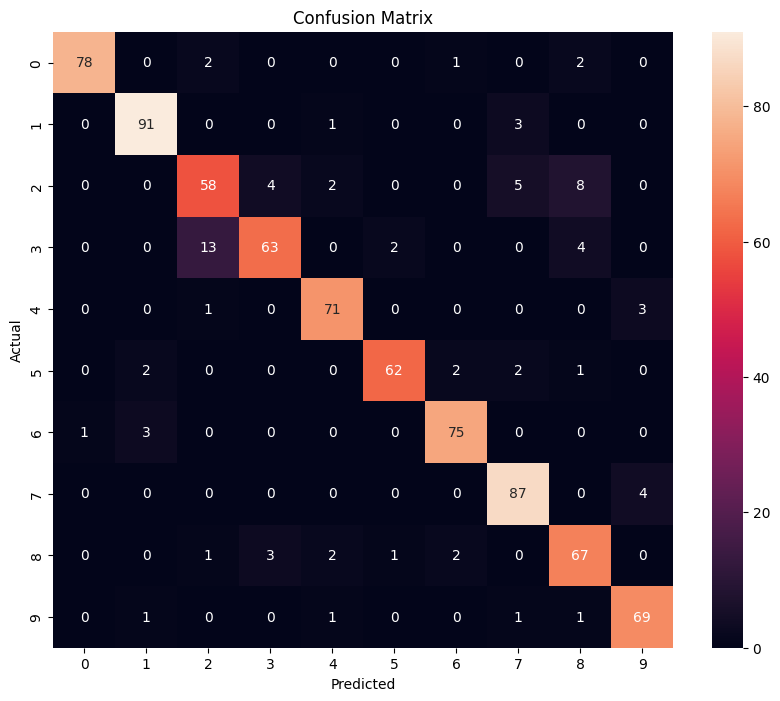

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        83
           1       0.94      0.96      0.95        95
           2       0.77      0.75      0.76        77
           3       0.90      0.77      0.83        82
           4       0.92      0.95      0.93        75
           5       0.95      0.90      0.93        69
           6       0.94      0.95      0.94        79
           7       0.89      0.96      0.92        91
           8       0.81      0.88      0.84        76
           9       0.91      0.95      0.93        73

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



In [ ]:
logsef32= run_experiment(32, features_efficient, show_metric=True)
with open('/content/drive/MyDrive/tmp/logsef32.pkl', 'wb') as file:
        pickle.dump(logsef32, file)

In [13]:
import numpy as np

test_acc = [0.935, 0.92375, 0.93375, 0.92625, 0.90375]

np.array(test_acc).mean()

0.9245000000000001

# efficient 100

In [ ]:
logsef100 = run_experiment(100, features_efficient)
with open('/content/drive/MyDrive/tmp/logsef100.pkl', 'wb') as file:
        pickle.dump(logsef100, file)

Data(x=[75, 100], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 100], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.053633516861333 | Train Accuracy 0.3166304347826087 | Test Loss 1.7392909435125499 | Test Accuracy 0.48625
Epoch 1 | Train Loss 1.4699265700247552 | Train Accuracy 0.5468478260869565 | Test Loss 1.195796223787161 | Test Accuracy 0.65875
Epoch 2 | Train Loss 1.025038472066323 | Train Accuracy 0.7051086956521739 | Test Loss 0.8524462626530573 | Test Accuracy 0.77875
Epoch 3 | Train Loss 0.7145008999440405 | Train Accuracy 0.8145652173913044 | Test Loss 0.6444507928994986 | Test Accuracy 0.83375
Epoch 4 | Train Loss 0.5127031029098563 | Train Accuracy 0.8593478260869565 | Test Loss 0.4894118010997772 | Test Accuracy 0.86125
Epoch 5 | Train Loss 0.4062823789815108 | Train Accuracy 0.8853260869565217 | Test Loss 0.4304135487629817 | Test Accuracy 0.88625
Epoch 6 | Train Loss 0.3404087987211015 | Train Accuracy 0.9110869565217391 

In [14]:
import numpy as np

test_acc = [0.94625, 0.92375, 0.9375, 0.9475, 0.9525]

np.array(test_acc).mean()

0.9414999999999999

# efficient 200

In [ ]:
logsef200 = run_experiment(200, features_efficient)
with open('/content/drive/MyDrive/tmp/logsef200.pkl', 'wb') as file:
        pickle.dump(logsef200, file)

Data(x=[75, 200], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 200], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.063984961145454 | Train Accuracy 0.3130434782608696 | Test Loss 1.8159910898942213 | Test Accuracy 0.40875
Epoch 1 | Train Loss 1.5175647644533052 | Train Accuracy 0.5164130434782609 | Test Loss 1.2583416333565345 | Test Accuracy 0.56875
Epoch 2 | Train Loss 1.0185463225675955 | Train Accuracy 0.6884782608695652 | Test Loss 0.8164034577516409 | Test Accuracy 0.78125
Epoch 3 | Train Loss 0.6715291618473 | Train Accuracy 0.8366304347826087 | Test Loss 0.601118972668281 | Test Accuracy 0.8525
Epoch 4 | Train Loss 0.46562732631961506 | Train Accuracy 0.8959782608695652 | Test Loss 0.4465439525934366 | Test Accuracy 0.88625
Epoch 5 | Train Loss 0.3344744817457265 | Train Accuracy 0.928804347826087 | Test Loss 0.3948494310562427 | Test Accuracy 0.8975
Epoch 6 | Train Loss 0.2591240509516663 | Train Accuracy 0.9454347826086956 | Te

In [15]:
import numpy as np

test_acc = [0.95625, 0.93625, 0.9475, 0.95, 0.94125]

np.array(test_acc).mean()

0.94625

# efficient 300

In [ ]:
logsef300 = run_experiment(300, features_efficient)
with open('/content/drive/MyDrive/tmp/logsef300.pkl', 'wb') as file:
        pickle.dump(logsef300, file)

Data(x=[75, 300], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 300], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.0440591068731413 | Train Accuracy 0.26565217391304347 | Test Loss 1.7477801946493297 | Test Accuracy 0.4225
Epoch 1 | Train Loss 1.4779738295409415 | Train Accuracy 0.5677173913043478 | Test Loss 1.182201284628648 | Test Accuracy 0.70875
Epoch 2 | Train Loss 0.9585956525471475 | Train Accuracy 0.7614130434782609 | Test Loss 0.7513474867894099 | Test Accuracy 0.83875
Epoch 3 | Train Loss 0.6032570654319392 | Train Accuracy 0.8769565217391304 | Test Loss 0.5285116181923792 | Test Accuracy 0.8775
Epoch 4 | Train Loss 0.4081512540578842 | Train Accuracy 0.9202173913043479 | Test Loss 0.4132346235788785 | Test Accuracy 0.9
Epoch 5 | Train Loss 0.28851401226388085 | Train Accuracy 0.9490217391304347 | Test Loss 0.33808182638425094 | Test Accuracy 0.92375
Epoch 6 | Train Loss 0.2149796309466991 | Train Accuracy 0.9621739130434782 |

In [16]:
import numpy as np

test_acc = [0.945, 0.95, 0.945, 0.96125, 0.945]

np.array(test_acc).mean()

0.9492499999999999

# dummy 5, all random

In [ ]:
run_experiment_no_pca(5, torch.rand(9200, 5), torch.rand(800, 5))

# dummy 32, all rand

In [ ]:
run_experiment_no_pca(32, torch.rand(9200, 32), torch.rand(800, 32))

# dummy 1, all rand

In [ ]:
run_experiment_no_pca(1, torch.rand(9200, 1), torch.rand(800, 1))

# concat sq+eff 5 + 5

In [ ]:
import numpy as np
features_sq_train = np.load('/content/drive/MyDrive/tmp/features_squeeze_train_false_TRAIN_pca5.npy')
features_eff_train = np.load('/content/drive/MyDrive/tmp/features_efficient_train_false_TRAIN_pca5.npy')
features_sq_val = np.load('/content/drive/MyDrive/tmp/features_squeeze_train_false_VALIDATION_pca5.npy')
features_eff_val = np.load('/content/drive/MyDrive/tmp/features_efficient_train_false_VALIDATION_pca5.npy')


train_features_pca = np.concatenate((features_sq_train, features_eff_train), axis=1)
val_features_pca = np.concatenate((features_sq_val, features_eff_val), axis=1)

In [ ]:
logsconcat10 = run_experiment_no_pca(10, train_features_pca, val_features_pca)
with open('/content/drive/MyDrive/tmp/logsconcat10.pkl', 'wb') as file:
        pickle.dump(logsconcat10, file)

Data(x=[75, 10], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 10], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.127581564916505 | Train Accuracy 0.2534782608695652 | Test Loss 1.8303316923288198 | Test Accuracy 0.39625
Epoch 1 | Train Loss 1.6540101112590895 | Train Accuracy 0.45130434782608697 | Test Loss 1.4541375728753896 | Test Accuracy 0.5375
Epoch 2 | Train Loss 1.3545573693182733 | Train Accuracy 0.5866304347826087 | Test Loss 1.2067948029591486 | Test Accuracy 0.6275
Epoch 3 | Train Loss 1.165692351344559 | Train Accuracy 0.6383695652173913 | Test Loss 1.0826831322449904 | Test Accuracy 0.66625
Epoch 4 | Train Loss 1.0743317964176338 | Train Accuracy 0.6661956521739131 | Test Loss 1.0163354185911326 | Test Accuracy 0.66875
Epoch 5 | Train Loss 1.0197349153459072 | Train Accuracy 0.6716304347826086 | Test Loss 0.9890824464651254 | Test Accuracy 0.67375
Epoch 6 | Train Loss 0.9796735122799873 | Train Accuracy 0.6867391304347826 | 

# concat sq+eff 2(sq) + 3(ef)


In [ ]:
import numpy as np
features_sq_train = np.load('/content/drive/MyDrive/tmp/features_squeeze_train_false_TRAIN_pca2.npy')
features_eff_train = np.load('/content/drive/MyDrive/tmp/features_efficient_train_false_TRAIN_pca3.npy')
features_sq_val = np.load('/content/drive/MyDrive/tmp/features_squeeze_train_false_VALIDATION_pca2.npy')
features_eff_val = np.load('/content/drive/MyDrive/tmp/features_efficient_train_false_VALIDATION_pca3.npy')


train_features_pca = np.concatenate((features_sq_train, features_eff_train), axis=1)
val_features_pca = np.concatenate((features_sq_val, features_eff_val), axis=1)

In [ ]:
logsconcat5 = run_experiment_no_pca(5, train_features_pca, val_features_pca)
with open('/content/drive/MyDrive/tmp/logsconcat5.pkl', 'wb') as file:
        pickle.dump(logsconcat5, file)

Data(x=[75, 5], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 5], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.0125722413261733 | Train Accuracy 0.29304347826086957 | Test Loss 1.757412992990934 | Test Accuracy 0.34375
Epoch 1 | Train Loss 1.5560344813598528 | Train Accuracy 0.4880434782608696 | Test Loss 1.4657539496055016 | Test Accuracy 0.52375
Epoch 2 | Train Loss 1.3356760715444882 | Train Accuracy 0.5470652173913043 | Test Loss 1.350614336820749 | Test Accuracy 0.55375
Epoch 3 | Train Loss 1.2538598883483145 | Train Accuracy 0.5647826086956522 | Test Loss 1.3008230924606323 | Test Accuracy 0.575
Epoch 4 | Train Loss 1.2181022465229034 | Train Accuracy 0.5752173913043478 | Test Loss 1.267210758649386 | Test Accuracy 0.575
Epoch 5 | Train Loss 1.1982029159035947 | Train Accuracy 0.582391304347826 | Test Loss 1.2264036306968102 | Test Accuracy 0.595
Epoch 6 | Train Loss 1.1802170984447002 | Train Accuracy 0.5856521739130435 | Test Los

# concat sq+eff 16 + 16

In [ ]:
import numpy as np
features_sq_train = np.load('/content/drive/MyDrive/tmp/features_squeeze_train_false_TRAIN_pca16.npy')
features_eff_train = np.load('/content/drive/MyDrive/tmp/features_efficient_train_false_TRAIN_pca16.npy')
features_sq_val = np.load('/content/drive/MyDrive/tmp/features_squeeze_train_false_VALIDATION_pca16.npy')
features_eff_val = np.load('/content/drive/MyDrive/tmp/features_efficient_train_false_VALIDATION_pca16.npy')


train_features_pca = np.concatenate((features_sq_train, features_eff_train), axis=1)
val_features_pca = np.concatenate((features_sq_val, features_eff_val), axis=1)

In [ ]:
logsconcat32 = run_experiment_no_pca(32, train_features_pca, val_features_pca)
with open('/content/drive/MyDrive/tmp/logsconcat32.pkl', 'wb') as file:
        pickle.dump(logsconcat32, file)

Data(x=[75, 32], edge_index=[2, 1405], y=[1], pos=[75, 2])
Data(x=[75, 32], edge_index=[2, 1395], y=[1], pos=[75, 2])
Starting training...
Epoch 0 | Train Loss 2.1180822120772467 | Train Accuracy 0.28119565217391307 | Test Loss 1.8865361213684082 | Test Accuracy 0.41125
Epoch 1 | Train Loss 1.6368648906548817 | Train Accuracy 0.5168478260869566 | Test Loss 1.4531041383743286 | Test Accuracy 0.55
Epoch 2 | Train Loss 1.2580581518510978 | Train Accuracy 0.6355434782608695 | Test Loss 1.1647697136952326 | Test Accuracy 0.675
Epoch 3 | Train Loss 1.0294256019923422 | Train Accuracy 0.7166304347826087 | Test Loss 0.9844398360985976 | Test Accuracy 0.72125
Epoch 4 | Train Loss 0.8893786937826209 | Train Accuracy 0.7503260869565217 | Test Loss 0.862889276101039 | Test Accuracy 0.745
Epoch 5 | Train Loss 0.7975763661993874 | Train Accuracy 0.7723913043478261 | Test Loss 0.8146938773301932 | Test Accuracy 0.7525
Epoch 6 | Train Loss 0.7351040653884411 | Train Accuracy 0.7867391304347826 | Test 

In [ ]:
import matplotlib.pyplot as plt

def plot_logs(logs1, logs2, title1='Experiment 1', title2='Experiment 2'):
    # Assuming logs1 and logs2 are structured as:
    # [train_losses, train_accuracies, test_losses, test_accuracies]

    # Plotting training and testing accuracy and loss for Experiment 1
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    for i, acc in enumerate(logs1[1]):  # Train accuracies
        plt.plot(acc, label=f'Run {i+1}')
    plt.title(f'{title1} - Training Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 2)
    for i, loss in enumerate(logs1[0]):  # Train losses
        plt.plot(loss, label=f'Run {i+1}')
    plt.title(f'{title1} - Training Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plotting training and testing accuracy and loss for Experiment 2
    plt.subplot(2, 2, 3)
    for i, acc in enumerate(logs2[1]):  # Train accuracies
        plt.plot(acc, label=f'Run {i+1}')
    plt.title(f'{title2} - Training Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 4)
    for i, loss in enumerate(logs2[0]):  # Train losses
        plt.plot(loss, label=f'Run {i+1}')
    plt.title(f'{title2} - Training Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

# You can call this function with your logs1 and logs2 variables.
# Example: plot_logs(logs1, logs2)
